<a href="https://colab.research.google.com/github/nsdumont/encoding-model-scaling-laws/blob/main/Semantic_Modularity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Encoding Model Scaling Laws Tutorial

This notebook is meant to provide a basic tutorial on how to use the data and models released for the paper "Scaling Laws for Language Encoding Models fMRI. As this is a scaling laws paper, be aware many of the files used by this notebook are ***large***. This notebook was tested on a machine with 128GB of RAM. We start with a few dependencies. The ridge_utils folder can be found in the same repository as this notebook.

In [ ]:
!pip install -U pycortex
!apt-get install -qq inkscape > /dev/null
filestore_path = '/usr/local/share/pycortex/'
config_file_path = '/root/.config/pycortex/options.cfg'

with open(config_file_path, 'r') as file:
    config_contents = file.read()

new_filestore_path = '/content/drive/My Drive/encoding-model-scaling-laws'

# Update the configuration contents
new_config_contents = config_contents.replace(filestore_path, new_filestore_path)

# Write the new configuration back to the file
with open(config_file_path, 'w') as file:
    file.write(new_config_contents)

print("Configuration file updated successfully.")

Configuration file updated successfully.


In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/encoding-model-scaling-laws')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#### Dependencies ####

import numpy as np
import logging
import sys
import time
import joblib
import matplotlib.pyplot as plt
import torch
import cortex # This dependency is pycortex, which enables the plotting of flatmaps. It can be disabled.
from cvxopt import matrix, solvers # Only necessary for the stacked model.
from transformers import AutoTokenizer, AutoModelForCausalLM # Only necessary for feature extraction.

# Repository imports
from ridge_utils.ridge import bootstrap_ridge
import ridge_utils.npp
from ridge_utils.util import make_delayed
from ridge_utils.dsutils import make_word_ds
from ridge_utils.DataSequence import DataSequence
from ridge_utils.tokenization_helpers import generate_efficient_feat_dicts_opt
from ridge_utils.tokenization_helpers import convert_to_feature_mats_opt

### Some extra helper functions

zscore = lambda v: (v - v.mean(0)) / v.std(0)
zscore.__doc__ = """Z-scores (standardizes) each column of [v]."""
zs = zscore

## Matrix corr -- find correlation between each column of c1 and the corresponding column of c2
mcorr = lambda c1, c2: (zs(c1) * zs(c2)).mean(0)
mcorr.__doc__ = """Matrix correlation. Find the correlation between each column of [c1] and the corresponding column of [c2]."""

### Ignore irrelevant warnings that muck up the notebook
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Some parameters
NUM_VOX = 95556 # Number of voxels in the subject we plan to use
NUM_TRS = 790 # Number of TRs across 3 test stories
trim_start = 50 # Trim 50 TRs off the start of the story
trim_end = 5 # Trim 5 off the back
ndelays = 4 # We use 4 FIR delays (2 seconds, 4 seconds, 6 seconds, 8 seconds)
delays = range(1, ndelays + 1)

## Semantic Encoding Model with pre-generated features

We start by building a basic semantic encoding model from layer 33 of OPT-30B using the preexisting features, weights, and responses from the [Box folder](https://utexas.box.com/v/EncodingModelScalingLaws). We load the features, apply some basic processing steps, and then dot the features with the encoding model weights to get our voxelwise predictions.

In [ ]:
### Running a basic semantic encoding model built from OPT layer 33 ###

# We are going to test our model on one of our held-out stories, "wheretheressmoke".
Tstories = ['wheretheressmoke']

# Load the precomputed OPT model hidden states from the Box
# From semantic_features folder
features = joblib.load("downsampled_featureseqs_opt33b_layer33.jbl")


# Trim and zscore the model features
Tstim = np.nan_to_num(np.vstack([ridge_utils.npp.zs(features[story][trim_start:-trim_end]) for story in Tstories]))

# Add FIR delays
delTstim = make_delayed(Tstim, delays)

# Load the linear encoding model weights for subject S02
# From ridge_weights folder
wt = joblib.load("S3_opt33b_wts_layer33.jbl")

# Dot the weights with the features to get voxelwise model predictions
pred = np.dot(delTstim,  wt)

Let's do a basic noise ceiling analysis using our new predictions. We will use the method of [Schoppe et al.](https://www.frontiersin.org/articles/10.3389/fncom.2016.00010/full), as we did  in our paper. Below is a short code snippet that implements their noise ceiling estimation method. We load the ground truth responses and compare them to our predictions using this code.

In [ ]:
def spe_and_cc_norm(orig_data, data_pred, data_norm=True, max_flooring=None):
    '''
    Computes the signal power explained and the cc_norm of a model given the observed and predicted values
    Assumes normalization unless data_norm is set to False

    orig_data: 3D numpy array (trials, timepoints, voxels)

    data_pred: 2D numpy array (timepoints, voxels)

    data_norm: bool -> Set to False if not pre-normalized

    max_flooring: None/float (0-1) -> If not None, compute cc_norm in an alternate way that floors cc_max by max_flooring.
    This is helpful to clean up bad voxels that are not at all language selective.

    According to Schoppe: https://www.frontiersin.org/articles/10.3389/fncom.2016.00010/full
    '''
    y = np.mean(orig_data, axis=0)
    num_trials = len(orig_data)
    if not data_norm:
        variance_across_time = np.var(orig_data, axis=1, ddof=1)
        TP = np.mean(variance_across_time, axis=0)
    else:
        TP = np.zeros(orig_data.shape[2]) + 1
    SP = (1 / (num_trials-1)) * ((num_trials * np.var(y, axis=0, ddof=1)) - TP)
    SPE_num = (np.var(y, axis=0, ddof=1) - np.var(y - data_pred, axis=0, ddof=1))
    SPE = (np.var(y, axis=0, ddof=1) - np.var(y - data_pred, axis=0, ddof=1)) / SP
    y_flip = np.swapaxes(y, axis1=0, axis2=1)
    data_flip = np.swapaxes(data_pred, axis1=0, axis2=1)
    covs = np.zeros(y_flip.shape[0])
    for i, row in enumerate(y_flip):
        covs[i] = np.cov(y_flip[i], data_flip[i])[0][1]
    cc_norm =  np.sqrt(1/SP) * (covs / np.sqrt(np.var(data_pred, axis=0, ddof=1)))
    cc_max = None
    if max_flooring is not None:
        cc_max = np.nan_to_num(1 / (np.sqrt(1 + ((1/num_trials) * ((TP/SP)-1)))))
        #cc_max = np.maximum(cc_max, np.zeros(cc_max.shape) + max_flooring)
        corrs = np.zeros(y_flip.shape[0])
        for i, row in enumerate(y_flip):
            corrs[i] = np.corrcoef(y_flip[i], data_flip[i])[0][1]
        cc_norm = corrs / cc_max
    return SPE, cc_norm, cc_max, corrs

# From responses folder
tensessions = joblib.load("tensessions_wheretheressmoke_S03.jbl")
SPE, cc_norm, cc_max, corrs_unnorm = spe_and_cc_norm(tensessions[:,40:,:], pred, max_flooring=0.25)

<ipython-input-6-e209fa429334>:32: RuntimeWarning: invalid value encountered in sqrt
  cc_norm =  np.sqrt(1/SP) * (covs / np.sqrt(np.var(data_pred, axis=0, ddof=1)))
<ipython-input-6-e209fa429334>:35: RuntimeWarning: invalid value encountered in sqrt
  cc_max = np.nan_to_num(1 / (np.sqrt(1 + ((1/num_trials) * ((TP/SP)-1)))))
<ipython-input-6-e209fa429334>:40: RuntimeWarning: divide by zero encountered in divide
  cc_norm = corrs / cc_max


Next, let's plot some simple performance metrics, like voxelwise correlation. These next few slides require Pycortex, you can skip them if you don't have it installed for our subjects on your machine. We assume here that you have the surface for UTS03 from our dataset in order to plot it. Here we filter voxels that are not language selective out by only selecting for voxels that have $cc_{max}$ > 0.35, and then we plot the resulting flatmap.

In [ ]:
cortex.options.config['basic']['filestore']

# cortex.database.default_filestore = '/content/drive/My Drive/encoding-model-scaling-laws'
# cortex.options.config['basic']['filestore'] = '/content/drive/My Drive/encoding-model-scaling-laws'
# # #!pip install ipdb

# ##%pdb off
# config_file_path


'/content/drive/My Drive/encoding-model-scaling-laws'

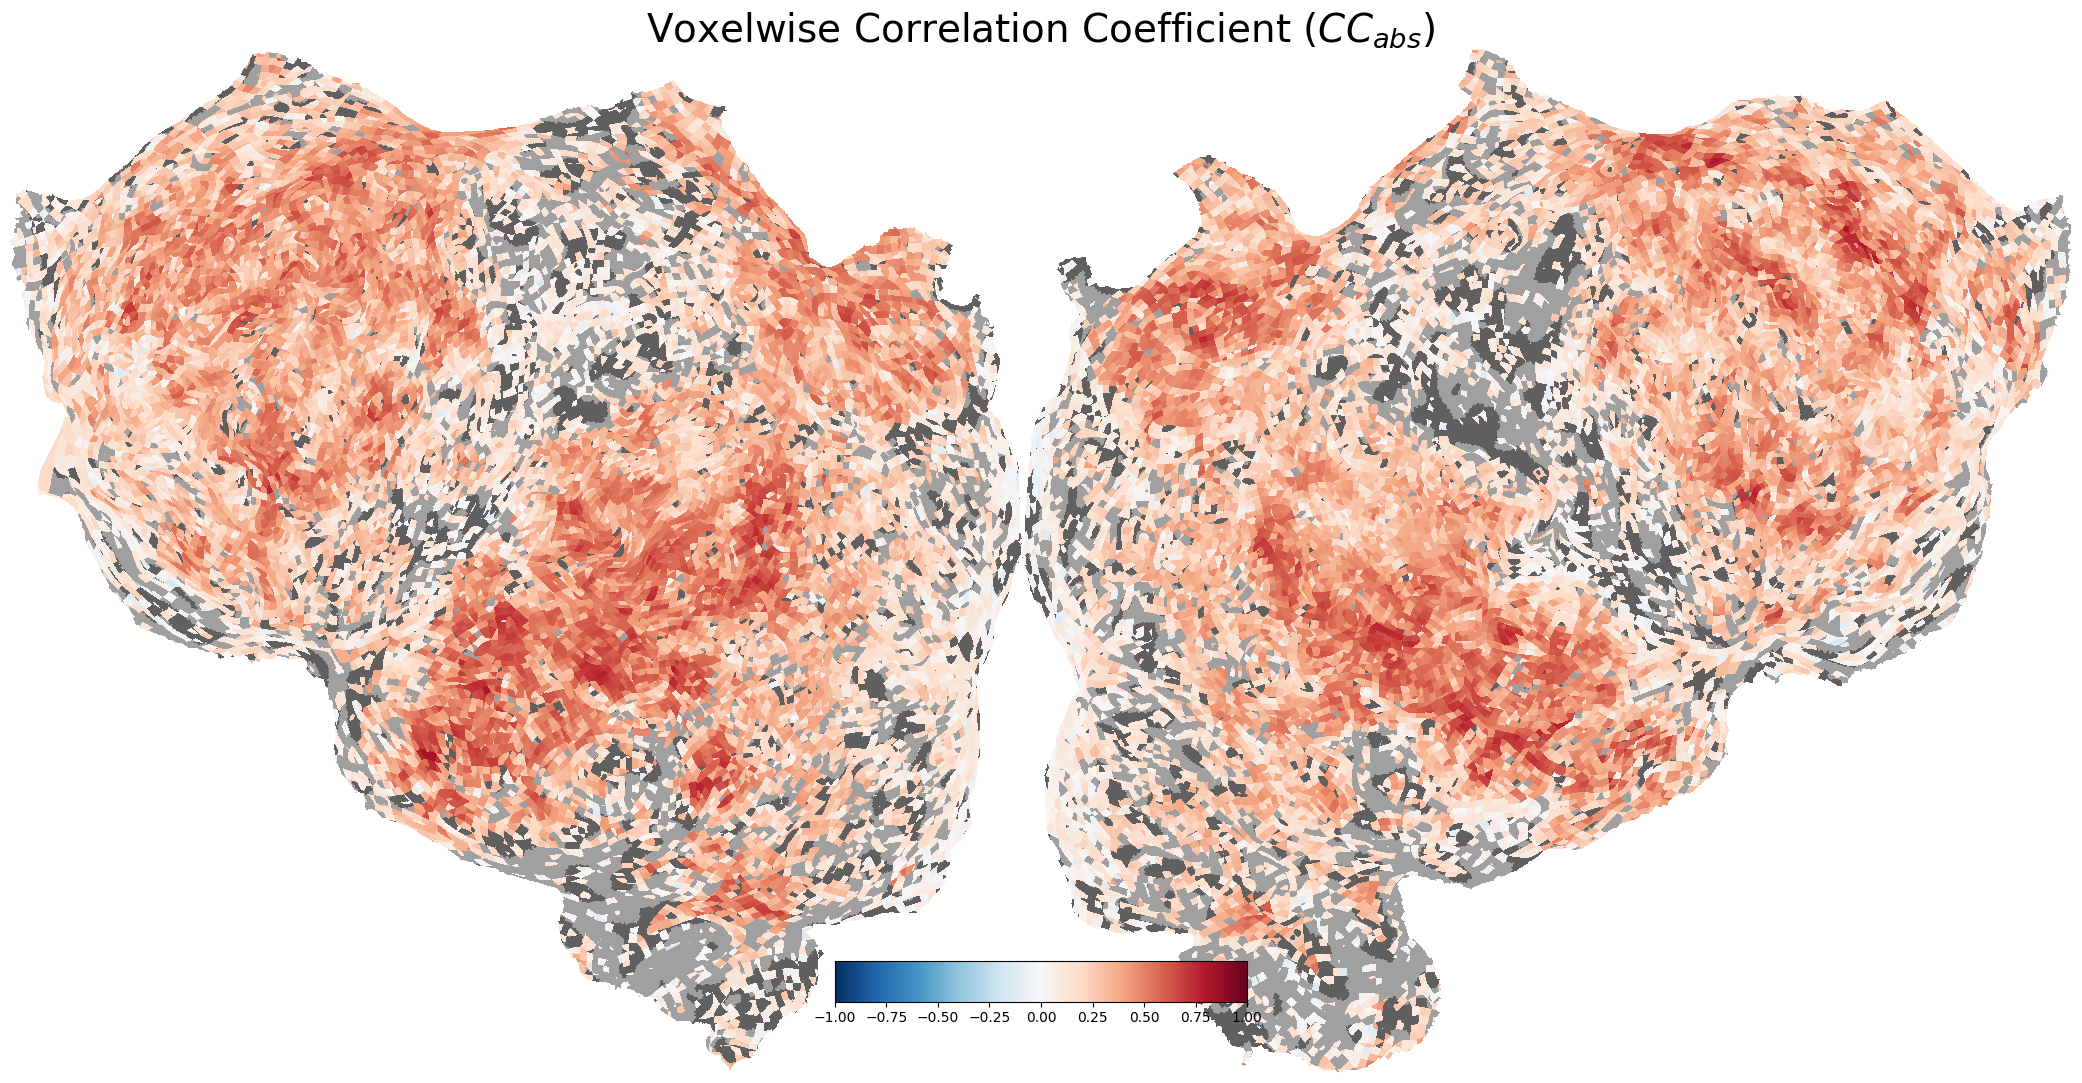

In [ ]:
acc = []
for ei, i in enumerate(cc_max):
    if i <= 0.35:
        acc.append(np.nan)
    else:
        acc.append(corrs_unnorm[ei])
acc = np.array(acc)
vol = cortex.Volume(acc, 'UTS03', 'UTS03', vmin=-1, vmax=1)
cortex.quickshow(vol, with_colorbar=True, linewidth=4, thick=1, with_curvature=True, with_rois=False)
plt.title("Voxelwise Correlation Coefficient ($CC_{abs}$)", size=28);

We can also plot the regions in cortex that have the most room for improvement based on the noise ceiling, like so:

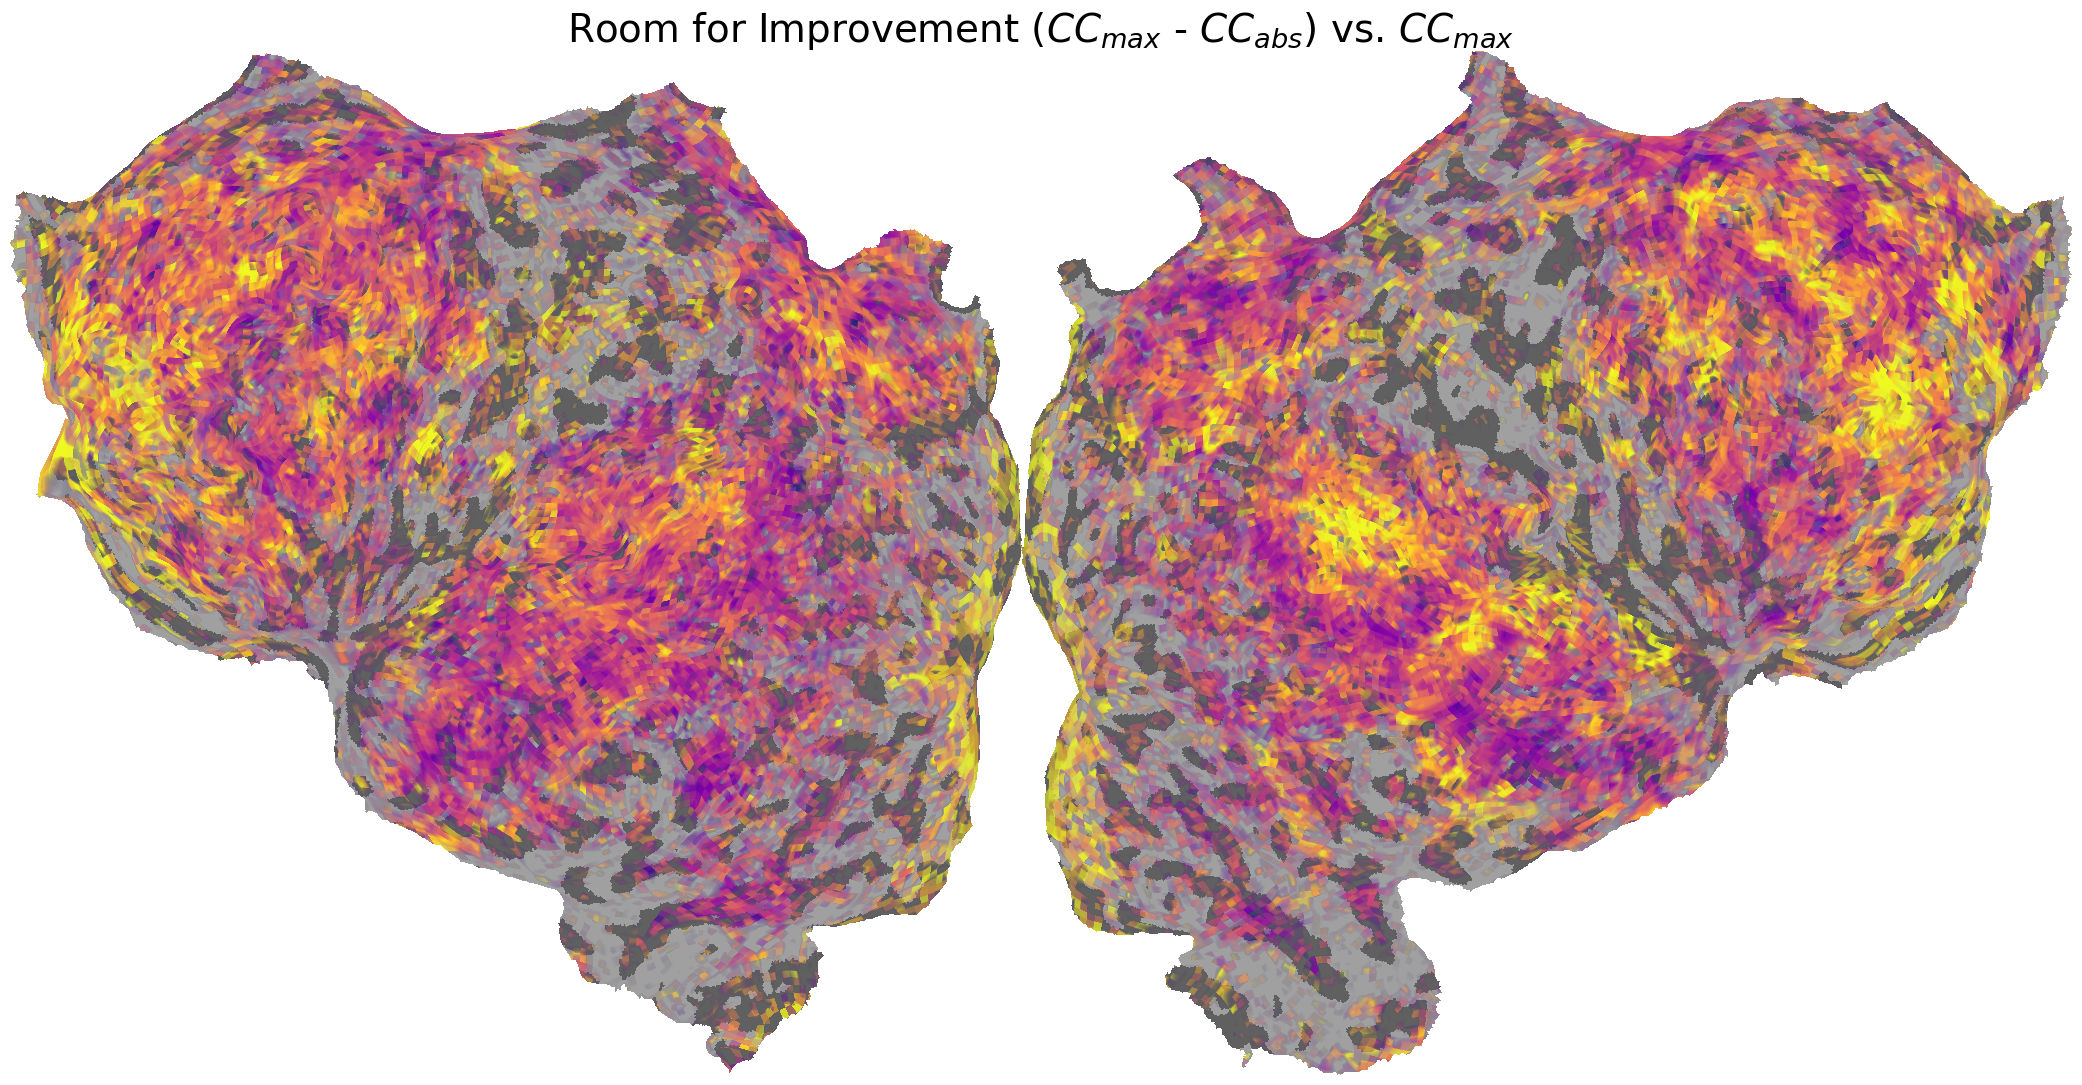

In [ ]:
acc = []
acc2 = []
for ei, i in enumerate(cc_max):
    if i <= 0.35:
        acc.append(np.nan)
        acc2.append(np.nan)
    else:
        acc.append(cc_max[ei] - corrs_unnorm[ei])
        acc2.append(cc_max[ei])
acc = np.array(acc)
acc2 = np.array(acc2)

corr2d = cortex.Volume2D(acc, acc2, 'UTS03', 'UTS03', vmin=0, vmax=0.5, vmin2=0.2, vmax2=0.7,
                        cmap="plasma_alpha")
cortex.quickshow(corr2d, with_curvature=True, with_labels=False,  with_rois=False, linewidth=5, with_colorbar=False);
plt.title("Room for Improvement ($CC_{max}$ - $CC_{abs}$) vs. $CC_{max}$", size=28);

We can also look at individual voxelwise timecourses and see how well we were able to predict them. Here's one voxel from this individual's right precuneus that we presented in our paper.

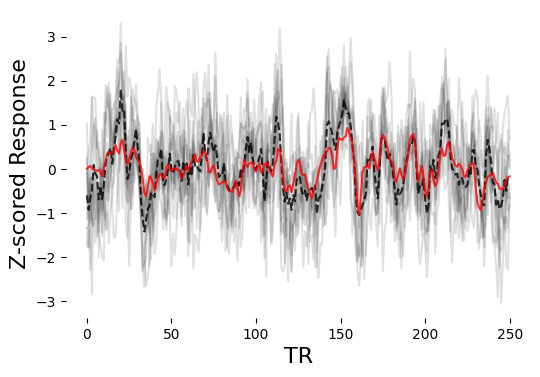

In [ ]:
fig, ax1 = plt.subplots(figsize=(6,4))
data = [i.T[55879] for i in tensessions[:,40:,:]]

for i in tensessions[:,40:,:]:
    plt.plot(i.T[55879], alpha=0.12, color='black')
mean_data = np.mean(data, axis=0)
plt.plot(mean_data, 'k--', alpha=0.8)
plt.plot(pred.T[55879], color='red', alpha=0.8)
plt.xlabel("TR", size=16)
plt.ylabel("Z-scored Response", size=16)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

## Stacked Encoding Model

Next, we will show how to use the joint speech and semantic stacked encoding model, based on [Lin et al.](https://pubmed.ncbi.nlm.nih.gov/37163111/). We start by taking the layerwise residual covariance matrix $\mathcal{R}$, which has been provided, and solving the quadratic program given in the paper. The resulting output gives us a set of attributions $\alpha^{v}$, stored in `acc_alphas`, per voxel.

In [ ]:
def quadratic_program_solver(R):
    k = len(R)

    P = matrix(np.array(R))
    q = matrix(np.zeros(k))

    # alpha_j ≥ 0 Constraint
    G = matrix(-np.eye(k))
    h = matrix(np.zeros(k))

    # sum(alpha_j) = 1 Constraint
    A = matrix(np.ones((1, k)))
    b = matrix(np.ones(1))

    # Solve the quadratic program
    solvers.options['show_progress'] = False
    solution = solvers.qp(P, q, G, h, A, b)

    return np.array(solution['x']).flatten()

# From stacked_regression folder
R = joblib.load("stacked_reg_R_mat_audio_S03.jbl")
R = R[:,1:,1:] # Don't use initial embedding layer, causes attribution issues
acc_alphas = []
for ei, i in enumerate(R):
    alphas = quadratic_program_solver(i)
    acc_alphas.append(alphas)

Next, we compute the final stacked encoding model given by $ \sum_{j=1}^{k} \alpha_{h_j}^{v}  f^{v,s}_{h_j}\left(\boldsymbol{x}_j\right)$. We provide the predictions in several files on the Box for readability, but they can be computed similarly to what was done in the previous section for the OPT weights.

In [ ]:
# All loaded files here are from the wheretheressmoke_preds subdirectory of the stacked_regression folder.
acc_alphas = np.array(acc_alphas)
pred = np.zeros((790,NUM_VOX))
for ei, i in enumerate(acc_alphas.T[:16]):
    layer_preds = joblib.load("test_preds_whisper_" + str(2*ei+2) + "_S03.jbl")
    for vox in range(NUM_VOX):
        pred[:, vox] += layer_preds[:, vox] * acc_alphas[vox][ei]
llama_layer_preds = joblib.load("test_preds_llama30B18_S03.jbl")
for vox in range(NUM_VOX):
    pred[:, vox] += layer_preds[:, vox] * acc_alphas[vox][16]

We then evaluate our stacked model on some validation data.

In [ ]:
# Load the ground truth val/test responses, also from stacked_regression folder
gt =  joblib.load("S03_test_stories_avg_resp.jbl")

stacked_acc_val_stacked = []
for i in range(NUM_VOX):
    stacked_acc_val_stacked.append(np.corrcoef(gt[:,i][251:], pred[:,i][251:])[0][1])

stacked_acc_val_sem = []
for i in range(NUM_VOX):
    stacked_acc_val_sem.append(np.corrcoef(gt[:,i][251:], llama_layer_preds[:,i][251:])[0][1])

We use this validation performance to generate a validation mask which we then use to decide which voxels use the stacked predictions instead of the semantic model predictions.

In [ ]:
stacked_acc_test_stacked = []
stacked_acc_test_sem = []
val_mask = np.array(stacked_acc_val_stacked) - np.array(stacked_acc_val_sem) > 0.05
for i in range(95556):
    if val_mask[i]:
        stacked_acc_test_stacked.append(np.corrcoef(gt[:,i][:251], pred[:,i][:251])[0][1])
    else:
        stacked_acc_test_stacked.append(np.corrcoef(gt[:,i][:251], llama_layer_preds[:,i][:251])[0][1])
    stacked_acc_test_sem.append(np.corrcoef(gt[:,i][:251], llama_layer_preds[:,i][:251])[0][1])

We can then plot how much better the stacked model is over the semantic model.

In [ ]:
vol = cortex.Volume(np.array(stacked_acc_test_stacked) - np.array(stacked_acc_test_sem), 'UTS03', 'UTS03', vmin=-0.5, vmax=0.5)
cortex.quickshow(vol, with_colorbar=False, linewidth=4, thick=1, with_curvature=True, with_rois=True, height=4096);

Generating a flatmap cache
Generating a flatmap cache
Failed to get connection
** (inkscape:15517): CRITICAL **: 23:13:17.922: dbus_g_proxy_new_for_name: assertion 'connection != NULL' failed
** (inkscape:15517): CRITICAL **: 23:13:17.922: dbus_g_proxy_call: assertion 'DBUS_IS_G_PROXY (proxy)' failed
** (inkscape:15517): CRITICAL **: 23:13:17.924: dbus_g_connection_register_g_object: assertion 'connection != NULL' failed
Background RRGGBBAA: ffffff00
Area 0:0:2062.8:1024 exported to 8251 x 4096 pixels (384 dpi)


We can also plot the convex attributions of the stacked model to see how represetations shift from preferring earlier speech model layers to later speech model layers. This can be visualized by a center-of-mass statistic of the attibution vector.

In [ ]:
com = []
for i in range(len(acc_alphas)):
    com_tmp = 0
    for j in range(16):
        com_tmp += j * acc_alphas[i][j]
    com.append(com_tmp)

And now we can plot this center-of-mass statistic on a flatmap.

In [ ]:
vol = cortex.Volume(np.array(com), 'UTS03', 'UTS03', vmin=0, vmax=16, cmap='fire')
cortex.quickshow(vol, with_colorbar=True, linewidth=4, thick=1, with_curvature=True, with_rois=True);

## Efficient Semantic Feature Extraction

Here we use some code that handles the tedious tokenization aspect of building LLM encoding models with our data. Our dataset is annotated at a per-word level, instead of a per-token level, so efforts need to be made to align the word annotations temporally with the features of the model. This can be done naively by using a fixed-length context window that changes per word, but this is _very slow_. Since we are dealing with large models on a tight computational budget, we want to avoid pointless recomputation as much as possible. We do this with a dynamic programming approach to minimize the number of forward passes that we will need to perform during actual feature extraction. Here, we build a set of dictionaries, `text_dict`, `text_dict2` and `text_dict3` that mark which contexts actually need to be run through the model. We use a non-fixed length sliding window which grows and shrinks at fixed intervals to minimize the number of forward passes that are required. The process can then be repeated in reverse to get the hidden state features in the proper order.

In [ ]:
#OPT

# These files are located in the story_data folder of the Box
grids = joblib.load("grids_huge.jbl") # Load TextGrids containing story annotations
trfiles = joblib.load("trfiles_huge.jbl") # Load TRFiles containing TR information

# We'll build an encoding model using this set of stories for this tutorial.
train_stories = ['adollshouse', 'adventuresinsayingyes', 'alternateithicatom', 'avatar', 'buck', 'exorcism',
            'eyespy', 'fromboyhoodtofatherhood', 'hangtime', 'haveyoumethimyet', 'howtodraw', 'inamoment',
            'itsabox', 'legacy', 'naked', 'odetostepfather', 'sloth',
            'souls', 'stagefright', 'swimmingwithastronauts', 'thatthingonmyarm', 'theclosetthatateeverything',
            'tildeath', 'undertheinfluence']

test_stories = ["wheretheressmoke"]

# Filter out the other stories for the tutorial
for story in list(grids):
    if story not in (train_stories + test_stories):
        del grids[story]
        del trfiles[story]

# Make datasequence for story
wordseqs = make_word_ds(grids, trfiles)

# We will be using a sliding context window with minimum size 256 words that increases until size 512 words.
tokenizer = AutoTokenizer.from_pretrained("facebook/opt-125m") # Same tokenizer for all sizes

# Make dictionary to align tokens and words
text_dict, text_dict2, text_dict3 = generate_efficient_feat_dicts_opt(wordseqs, tokenizer, 256, 512)


# We are going to use the 125m parameter model for this tutorial, but any size should work
model = AutoModelForCausalLM.from_pretrained("facebook/opt-125m")

# We will extract features from the 9th layer of the model
LAYER_NUM = 9

start_time = time.time()
for phrase in text_dict2:
    if text_dict2[phrase]:
        inputs = {}
        inputs['input_ids'] = torch.tensor([text_dict[phrase]]).int()
        inputs['attention_mask'] = torch.ones(inputs['input_ids'].shape)
        out = list(model(**inputs, output_hidden_states=True)[2])
        out = out[LAYER_NUM][0].cpu().detach().numpy()
        out = np.array(out)
        this_key = tuple(inputs['input_ids'][0].cpu().detach().numpy())
        acc_true = 0
        for ei, i in enumerate(this_key):
            if this_key[:ei+1] in text_dict3:
                acc_true += 1
                text_dict3[this_key[:ei+1]] = out[ei,:]
end_time = time.time()

print("Feature extraction took", end_time - start_time, "seconds on", model.device)
# Convert back from dictionary to matrix
feats = convert_to_feature_mats_opt(wordseqs, tokenizer, 256, 512, text_dict3)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/651 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/251M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

Feature extraction took 71.66463994979858 seconds on cpu


We can now use these features to create new encoding model weights and test them on some held-out data.

In [ ]:
# Same preprocessing as before
# trim off a little more for artifact correction at test time.

#Training data
Rstim = np.nan_to_num(np.vstack([ridge_utils.npp.zs(feats[story][10:-5]) for story in train_stories]))

#Test data
Pstim = np.nan_to_num(np.vstack([ridge_utils.npp.zs(feats[story][trim_start:-trim_end]) for story in test_stories]))

# Add FIR delays
delRstim = make_delayed(Rstim, delays)
delPstim = make_delayed(Pstim, delays)

alphas = np.logspace(1, 4, 15) # Equally log-spaced ridge parameters between 10 and 10000.
nboots = 3 # Number of cross-validation ridge regression runs. You can lower this number to increase speed.

# Get response data
resp_dict = joblib.load("UTS03_responses_small.jbl") # Located in story_responses folder
Rresp = np.vstack([resp_dict[story] for story in train_stories])
Presp = np.vstack([resp_dict[story][40:] for story in test_stories])

# Bootstrap chunking parameters
chunklen = 20
nchunks = int(len(Rresp) * 0.25 / chunklen)

# Run ridge regression - this might take some time
wt, corr, alphas, bscorrs, valinds = bootstrap_ridge(delRstim, Rresp, delPstim, Presp,
                                                     alphas, nboots, chunklen, nchunks,
                                                     use_corr=False, single_alpha=False)

And we can plot the resulting test performance...

Failed to get connection
** (inkscape:24735): CRITICAL **: 23:49:22.641: dbus_g_proxy_new_for_name: assertion 'connection != NULL' failed
** (inkscape:24735): CRITICAL **: 23:49:22.641: dbus_g_proxy_call: assertion 'DBUS_IS_G_PROXY (proxy)' failed
** (inkscape:24735): CRITICAL **: 23:49:22.641: dbus_g_connection_register_g_object: assertion 'connection != NULL' failed
Background RRGGBBAA: ffffff00
Area 0:0:2062.8:1024 exported to 2063 x 1024 pixels (96 dpi)


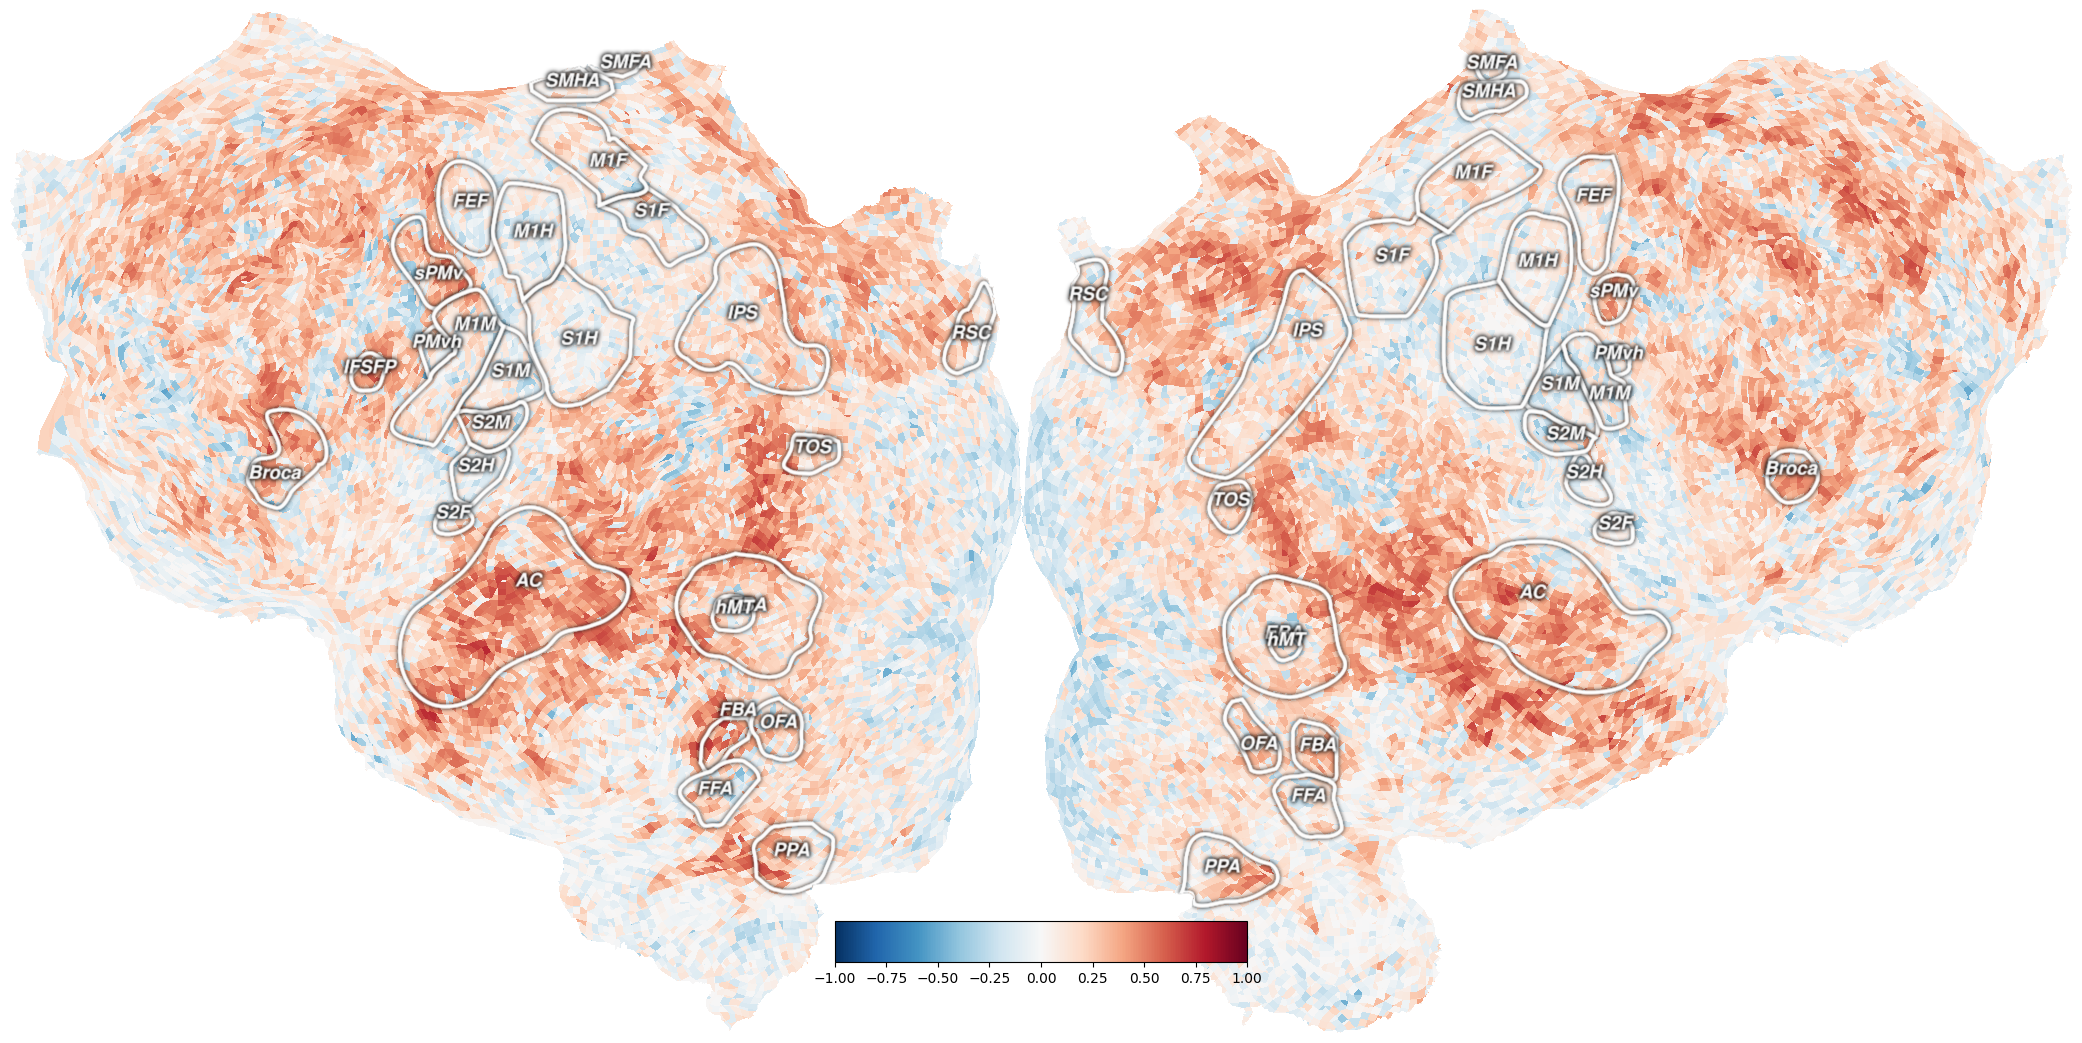

In [ ]:
vol = cortex.Volume(np.array(corr), 'UTS03', 'UTS03', vmin=-1, vmax=1, )
cortex.quickshow(vol, with_colorbar=True, linewidth=4, thick=1, with_curvature=True, with_rois=True);

This concludes the tutorial. If you have additional questions about how to use our dataset, or about the paper, feel free to contact rjantonello@utexas.edu. If these data or models were helpful for your own work please cite our paper using the following BibTex citation:

```
@article{antonello2023scaling,
  title={Scaling laws for language encoding models in fMRI},
  author={Richard J. Antonello and Aditya R. Vaidya and Alexander G. Huth},
  journal={Advances in Neural Information Processing Systems},
  volume={36},
  year={2023}
}
```